<a href="https://colab.research.google.com/github/chho-work/biovision/blob/main/nb/AntimicrobialDisk_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

Detectron2, the Mask RCNN based detector, created by Facebook Research AI, is the framework that I will use to detect antibiogram's zone of inhibition and disks.<br>

The training data will be the 53 images and its corresponding annotations created in notebooks: "Synthetic_Images_Antibiogram.ipynb" and "Convert2JSON(COCO)".

I will not use any data for validation.  I did not include validation as this notebook is more focused on the process rather than model accuracy, and also due to small sample size.  However, please note that it is not a good practice to leave validation out of your training-validation-test process.

There are two test images and I will use one of them to perform inference.  The inference results will output detected zone of inhibition and disks.  You could use the other one to try them yourself.  The focus on this last part will the measure of zone of inhibition.   



### Setup

In [1]:
# Check for GPU availability
!nvidia-smi

Sun Dec 13 13:01:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
# install dependencies to run Detectron2 
# opencv is pre-installed on colab

!pip install cython pyyaml==5.1 pycocotools>=2.0.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

!gcc --version

In [19]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

**Check prior cell output, if you see this message "You must restart the runtime in order to use newly installed versions." Make sure you restart!**

In [20]:
# Install tree to display dirs using Bash
!apt-get -q install tree

In [2]:
# Clone this repo.
!git clone https://github.com/chho-work/biovision.git

Cloning into 'biovision'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (337/337), done.
remote: Compressing objects: 100% (257/257), done.
remote: Total 337 (delta 128), reused 249 (delta 67), pack-reused 0
Receiving objects: 100% (337/337), 4.42 MiB | 34.00 MiB/s, done.
Resolving deltas: 100% (128/128), done.


### Import Library

In [1]:
# Pytorch
import torch, torchvision
print(torchvision.__version__, torch.cuda.is_available())

0.8.1+cu101 True


In [2]:
# detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# detectron2 utilities
from detectron2 import model_zoo
from detectron2 .config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer, ColorMode

# Other libraries
import cv2 # OpenCV
from google.colab.patches import cv2_imshow
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
from pathlib import Path

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



### Build Path to Dataset

In [3]:
# base directory to data
base_path_data = Path('/content/biovision/data')

# base directory for images
base_path_image = base_path_data.joinpath('images')

# background image directory
back_path = base_path_image.joinpath('background')

# foreground image directory
fore_path = base_path_image.joinpath('foreground')

# output file directory
output_path = base_path_image.joinpath('output')

# test image directory
test_path = base_path_image.joinpath('test')
test_path.mkdir(parents=True, exist_ok=True)

# train directory containing all the training images
train_path = base_path_image.joinpath('train')
train_path.mkdir(parents=True, exist_ok=True)

# annotation directory for annotated data
annot_path = base_path_data.joinpath('annotations')
annot_path.mkdir(parents=True, exist_ok=True)

### Download Images and Annotation

In [5]:
# Download 53 images created in previous notebooks.
!gdown --id 1sIeCJ2YuEzYAexzx-be7Fd7x-CQrFKjt

# The annotations for these 53 images has been uploaded to github and 
#  you can find them under annotations directory in annotations.json

Downloading...
From: https://drive.google.com/uc?id=1sIeCJ2YuEzYAexzx-be7Fd7x-CQrFKjt
To: /content/synthetic_antibiogram_image.zip
4.45MB [00:00, 39.0MB/s]


In [6]:
# Unzip to train directory.
!unzip /content/synthetic_antibiogram_image.zip -d {train_path}

### Register Dataset and Add Metadata

In [4]:
# Use register_coco_instances() to register antibiogram_train(already in COCO format).
register_name = 'biovision'
annotation = str(annot_path.joinpath('annotations.json'))
train =  str(train_path)
register_coco_instances(register_name, 
                        {}, 
                        annotation, 
                        train)

In [5]:
# MetadataCatalog is a key-value mapping which contains names of classes, colors of classes, root of files, etc. 
bio_train_metadata = MetadataCatalog.get(register_name)

# A global dictionary which contains information about the datasets.
# It also makes it easier to choose different datasets, by just using the strings in the config.
dataset_dicts_train = DatasetCatalog.get(register_name)

WARNING [12/13 12:08:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/13 12:08:51 d2.data.datasets.coco]: Loaded 52 images in COCO format from /content/biovision/data/annotations/annotations.json


In [6]:
print(bio_train_metadata)

Metadata(evaluator_type='coco', image_root='/content/biovision/data/images/train', json_file='/content/biovision/data/annotations/annotations.json', name='biovision', thing_classes=['disk', 'zone'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1})


### Visualize Images

In [7]:
# Print data/images directory
!tree /content/biovision/data/images

/content/biovision/data/images
├── annotation
├── background
│   └── 9_antibiogram_empty_petri.jpg
├── coco_annotation
├── foreground
│   ├── disk_AML25.png
│   ├── zone_CT25_disk.png
│   └── zone_CT25.png
├── readme
│   ├── 9_antibiogram_raw.jpg
│   ├── Agar_Diffusion_Method_1.jpg
│   ├── Agar_Diffusion_Method_2.jpg
│   ├── antibiogram-process.jpg
│   ├── antimicrobial_disks.png
│   ├── measure-ruler.jpg
│   ├── process_flow.png
│   ├── synthetic_annotation.jpg
│   └── synthetic_image.jpg
├── test
│   ├── test_image_1.jpg
│   └── test_image_2.jpg
└── train
    ├── synthetic_antibiogram_10.jpg
    ├── synthetic_antibiogram_11.jpg
    ├── synthetic_antibiogram_12.jpg
    ├── synthetic_antibiogram_13.jpg
    ├── synthetic_antibiogram_14.jpg
    ├── synthetic_antibiogram_15.jpg
    ├── synthetic_antibiogram_16.jpg
    ├── synthetic_antibiogram_17.jpg
    ├── synthetic_antibiogram_18.jpg
    ├── synthetic_antibiogram_19.jpg
    ├── synthetic_antibiogram_1.jpg
    ├── synthetic_antibiogram_

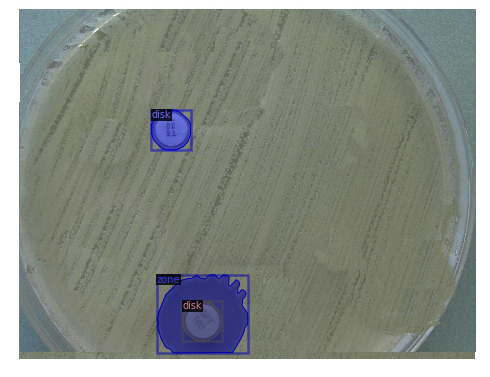

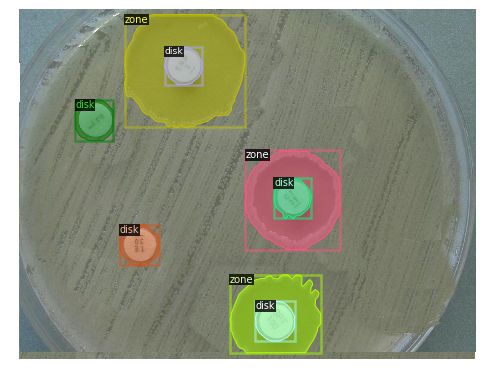

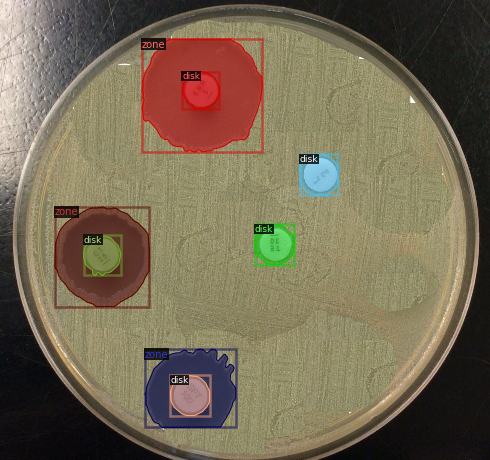

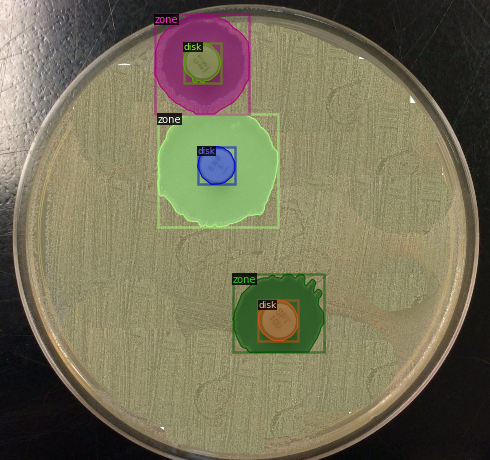

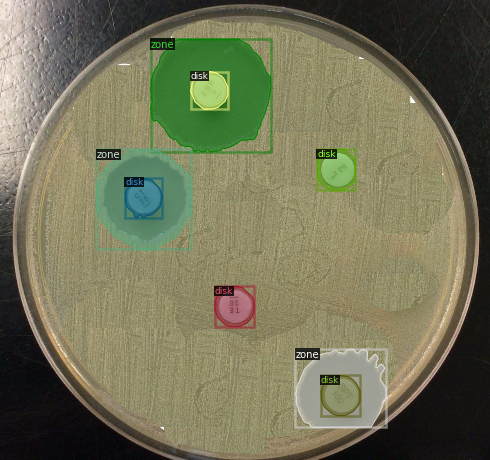

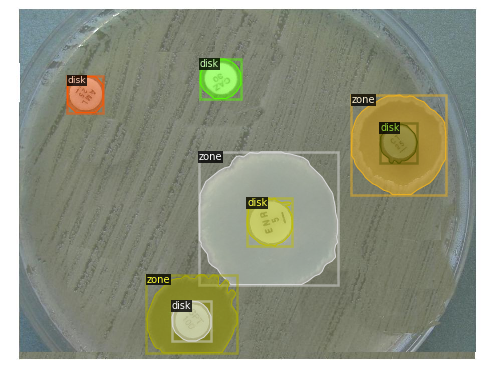

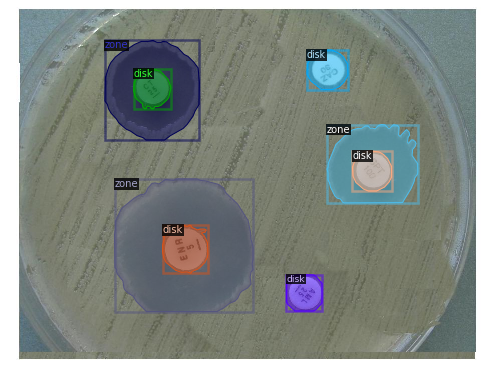

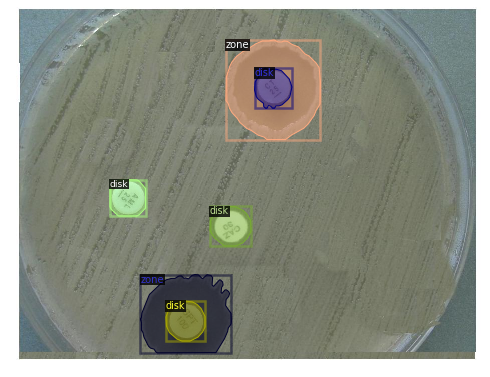

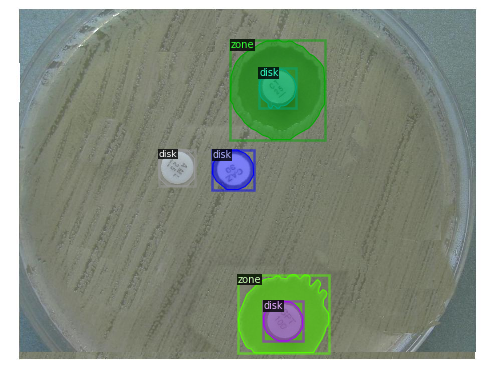

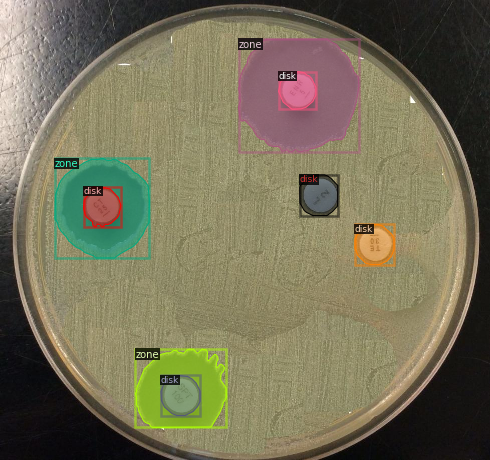

In [8]:
# Change the number of images to display using the second parameter of the "for loop"
for d in random.sample(dataset_dicts_train, 10):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=bio_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])
    print('\n')

### Trainer

In [9]:
# COCOEvaluator enables evaluation of:
# AP (Average Precision) for box detection, instance segmentation, keypoint detection on any custom dataset,
#  using dataset's official API.

class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [10]:
# Obtain detectron2's default config
cfg = get_cfg() 

# Load values from a file
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Add new configs custom components
cfg.DATASETS.TRAIN = (register_name,) # training images; remember to add ",", dtype: tuple
cfg.DATASETS.TEST = () # validation images; remember to add ",", dtype: tuple
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # initialize from model zoo
#cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2 # images per batch
cfg.SOLVER.BASE_LR = 0.02 # mininum learning rate

cfg.SOLVER.WARMUP_ITERS = 1000 
cfg.SOLVER.MAX_ITER = 2000    
cfg.SOLVER.STEPS = (1000, 1500) 

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 164 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 1 classe (rot)

cfg.TEST.EVAL_PERIOD = 100 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False) 
trainer.train() # Training 

### Inference

* Recommended image size for inference min of 912 x 684 pixels.

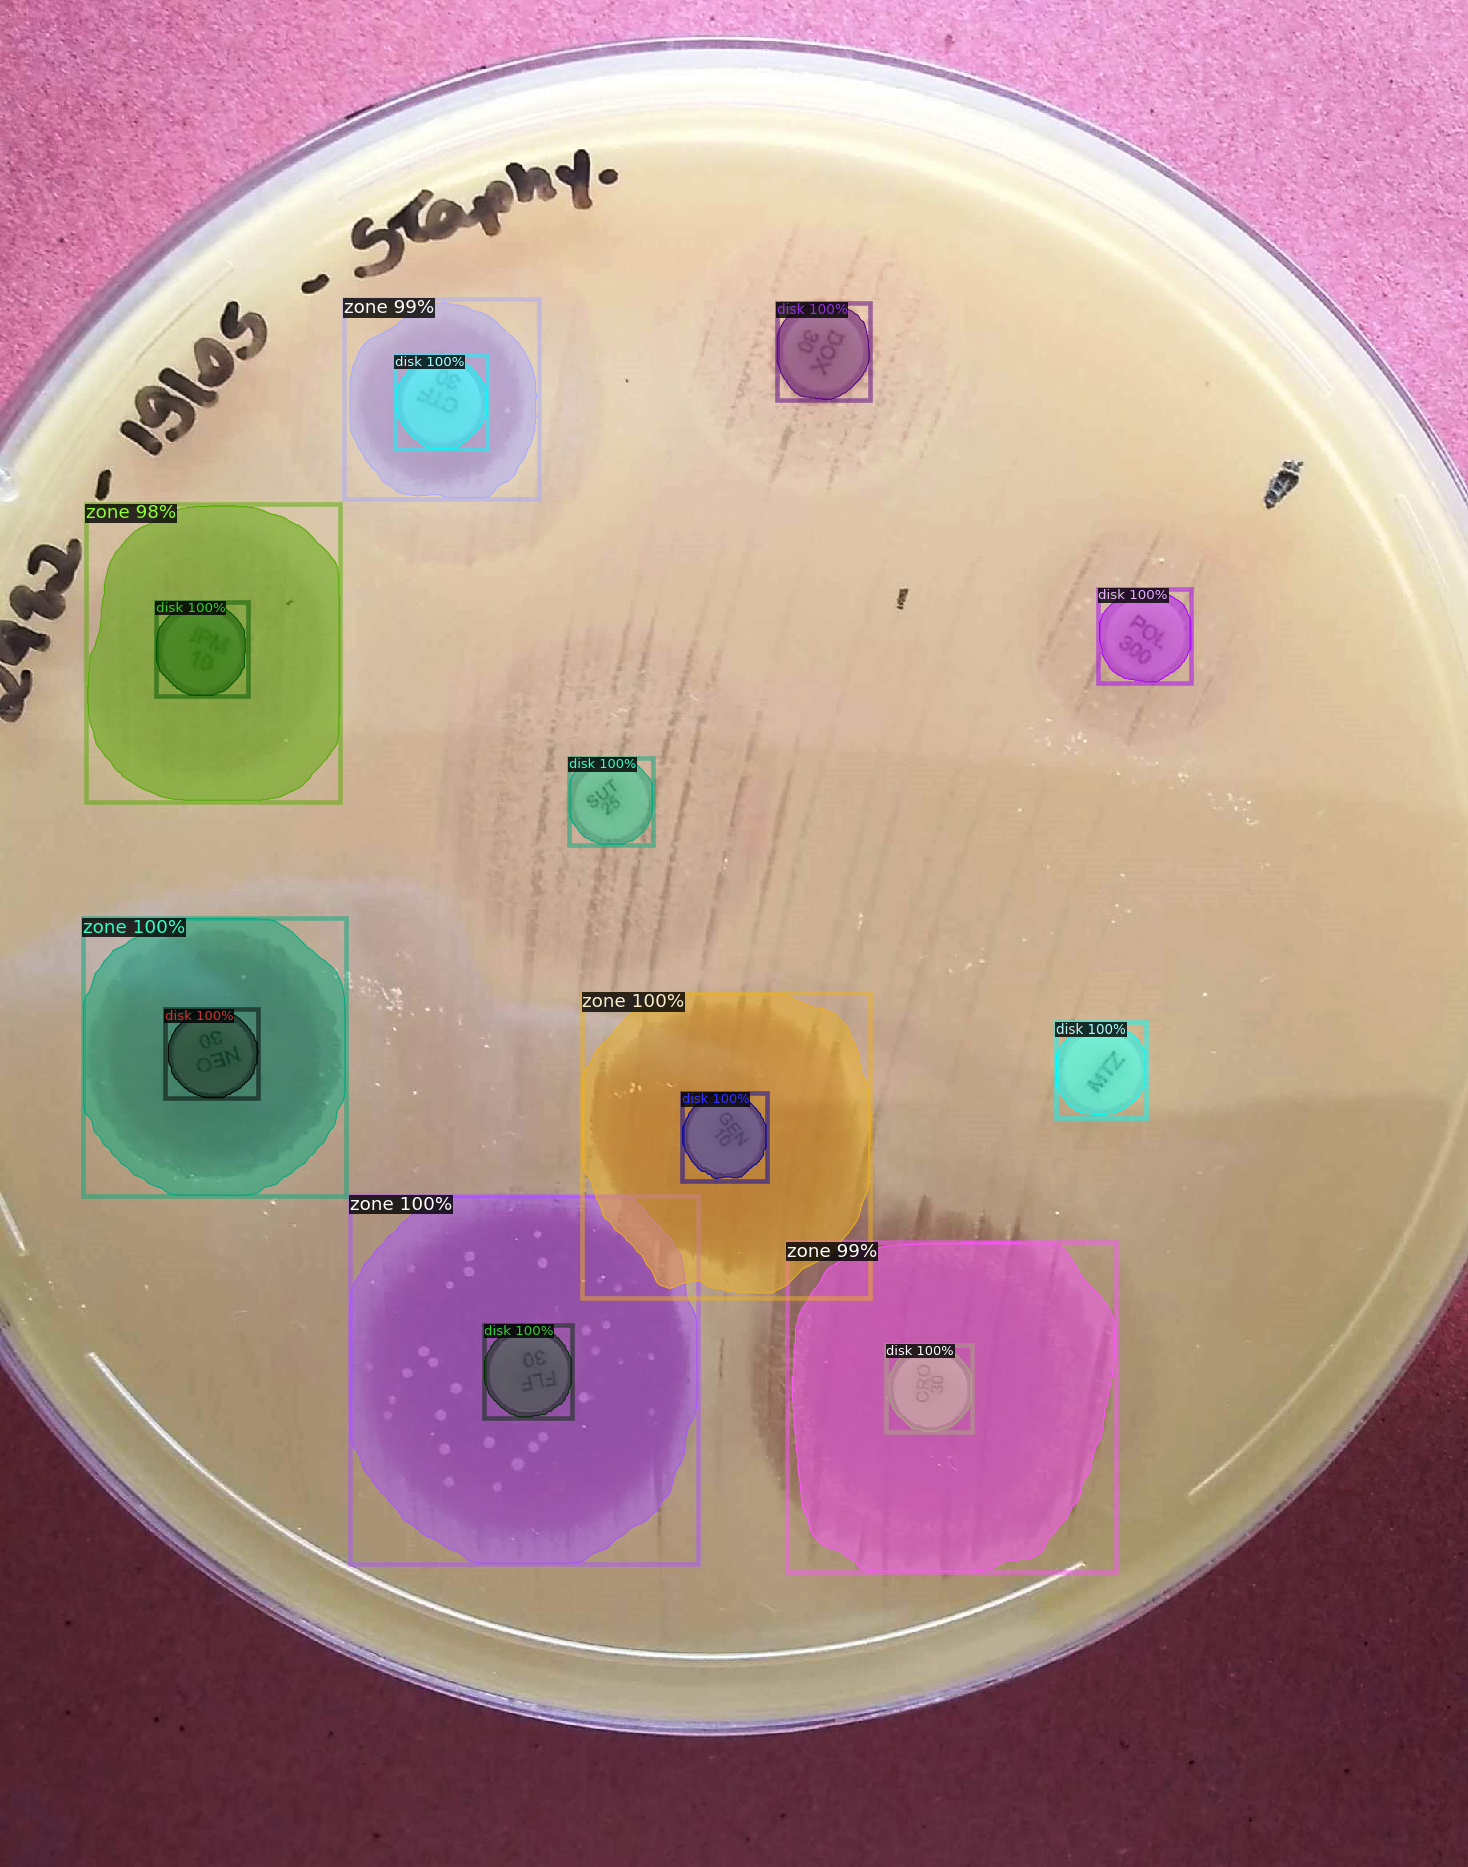

In [54]:
# Inference antibiogram images.
inference_image_2 = test_path.joinpath('test_image_2.jpg')
im = cv2.imread(str(inference_image_2))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
outputs_inference_image_2 = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),scale=0.8)
out = v.draw_instance_predictions(outputs_inference_image_2["instances"].to("cpu"))
#out.save('/content/test_image_1_inference.jpg')
cv2_imshow(out.get_image()[:, :, ::-1])

### Find and Measure Zone of Inhibition

In the above image, it was detected 16 objects(zone of inhibition and disks).  Remember that for each zone of inhibition we have a disk and we have also disk as a single category.<br>  

We can find with Detectron2 the prediction classes and bounding boxes(bbox).

1. Use zip to pair predicted class with bbox together.
2. Enumerate each predicted class: disk(0) and zone of inhibtion(1).
3. Choose one zone of inhibition and crop with the size of bbox.    
4. Find the contours of the zone of inhibition in the new cropped image.
5. Draw a rectangle around the contour and use the length of rectangle to find the size of zone of inhibition.  

In [13]:
# Total number of classes detected: zone of inhibition + disks
output_pred_classes = outputs_inference_image_2["instances"].pred_classes
pred_classes = output_pred_classes.tolist()
print(f'Total number of categories predicted: zone of inhibition + disks: {len(output_pred_classes)}')
print("class disk = 0\nclass zone of inhibtion = 1")
print(f'Prediction classes for each category detected, filtered in a list: {pred_classes}')

Total number of categories predicted: zone of inhibition + disks: 16
class disk = 0
class zone of inhibtion = 1
Prediction classes for each category detected, filtered in a list: [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]


In [14]:
# List of bboxes coordinates.
output_pred_boxes = outputs_inference_image_2["instances"].pred_boxes
print(f'Total number of bounding boxes: {len(output_pred_boxes)}')

box_coordinate = []
for i in output_pred_boxes.__iter__():
    coord = (i.cpu().numpy()) # dytpe: numpy
    coord_list = coord.tolist()
    box_coordinate.append(coord_list)

# print(f'Bounding box coordinate: {box_coordinate}')
print(f'First bounding box coordinate: {box_coordinate[0]}')

Total number of bounding boxes: 16
First bounding box coordinate: [103.76889038085938, 1148.3212890625, 431.9642028808594, 1495.0438232421875]


In [15]:
# Convert to bbox area, height and width
box_area = []
coordinate_list = []
height_width = []
for b in range(len(box_coordinate)):
    #print(f'box = {box_coordinate[b]}')
    coord_box = box_coordinate[b]
    for i in range(4):
        if i == 0:
            x1 = coord_box[i]
            #print(f'x1 = {x1}')
        elif i == 1:
            y1 = coord_box[i]
            #print(f'y1 = {y1}')
        elif i == 2:
            x2 = coord_box[i]
            #print(f'x2 = {x2}')
        elif i == 3:
            y2 = coord_box[i]
            #print(f'y2 = {y2}')
    
    coordinate_list.append([x1, y1, x2, y2])    
    height = y2 - y1
    width = x2 - x1
    box_area.append([height * width])
    height_width.append([height, width])
    # print(f'h x w = {(height, width)}')
    # print(f'h * w = {height * width}')
        

In [16]:
print(f'Height x Width of the first bbox: {height_width[0]}')

Height x Width of the first bbox: [346.7225341796875, 328.1953125]


In [17]:
# Match the prediction classes with their corresponding bounding boxes.
# Enumerate the results of the above.
match = zip(pred_classes, box_coordinate)
for _cat, _coord in enumerate(match):
    print(_cat, _coord)

0 (1, [103.76889038085938, 1148.3212890625, 431.9642028808594, 1495.0438232421875])
1 (0, [852.494873046875, 1366.5645751953125, 958.527587890625, 1476.395751953125])
2 (1, [727.9492797851562, 1241.543212890625, 1087.587890625, 1622.931884765625])
3 (1, [437.01995849609375, 1494.8756103515625, 872.2048950195312, 1955.1378173828125])
4 (0, [970.6639404296875, 378.9625244140625, 1087.4056396484375, 500.5935363769531])
5 (0, [205.8702850341797, 1261.873291015625, 322.5579528808594, 1373.3646240234375])
6 (0, [711.2188110351562, 947.8016357421875, 815.9908447265625, 1056.14208984375])
7 (0, [1108.0445556640625, 1680.9573974609375, 1215.44921875, 1790.7755126953125])
8 (0, [194.5439453125, 752.4813232421875, 310.1521911621094, 870.225830078125])
9 (0, [493.9080810546875, 444.4725646972656, 608.923583984375, 561.5648193359375])
10 (0, [1373.0997314453125, 736.6538696289062, 1488.826904296875, 853.6010131835938])
11 (0, [605.3316040039062, 1655.919677734375, 714.7517700195312, 1772.9466552734

In [18]:
# List of category zone(1)
#box_area.sort(reverse=True)
zone_inhibition_list = []
match = zip(pred_classes, box_coordinate)
for _cat, _coord in match:
    #print(k, v)
    if _cat == 1:
        zone_inhibition_list.append(_coord)

print(f'Bbox of every zone of inhibition detected {zone_inhibition_list}')
print(f'Total number of zone of inhibition: {len(zone_inhibition_list)}')

Bbox of every zone of inhibition detected [[103.76889038085938, 1148.3212890625, 431.9642028808594, 1495.0438232421875], [727.9492797851562, 1241.543212890625, 1087.587890625, 1622.931884765625], [437.01995849609375, 1494.8756103515625, 872.2048950195312, 1955.1378173828125], [983.6079711914062, 1553.1197509765625, 1394.782470703125, 1964.842529296875], [429.7940673828125, 373.96356201171875, 674.024658203125, 623.7538452148438], [107.05307006835938, 630.571044921875, 424.5819396972656, 1002.1632080078125]]
Total number of zone of inhibition: 6


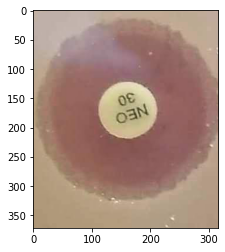

In [19]:
# Crop the first zone of inhibition detected
from matplotlib.pyplot import imshow
from PIL import Image

%matplotlib inline

# Open image
im = Image.open(inference_image_2, 'r')
z = zone_inhibition_list

id = 0
left = z[id][0] 
top = z[id][1] 
width = height_width[15][1] # height_width[0][0] # left + width
height = height_width[15][0] # height_width[0][1] # top + right

box = (left, top, left + width, top + height)
crop_result = im.crop(box)
crop_result.save('/content/crop_result_1.jpg')
imshow(np.asarray(crop_result))

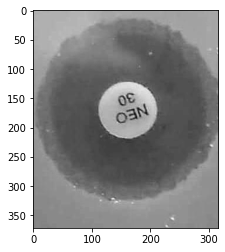

In [20]:
# Convert to gray
_img = Image.open('/content/crop_result_1.jpg')
open_cv_image = np.array(_img) 

gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray)
plt.gray()
plt.show()

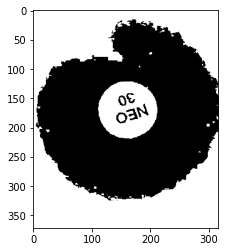

46


In [21]:
# binarize image
retval_binary, bw_binary = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# find contour
contours_binary, hierarchy_binary = cv2.findContours(bw_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(bw_binary)
plt.show()

print(len(contours_binary))

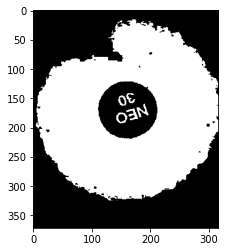

43


In [22]:
# binary, inv image
retval_inv, bw_inv = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

# find contour
contours_inv, hierarchy_inv = cv2.findContours(bw_inv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(bw_inv)
plt.show()

print(len(contours_inv))

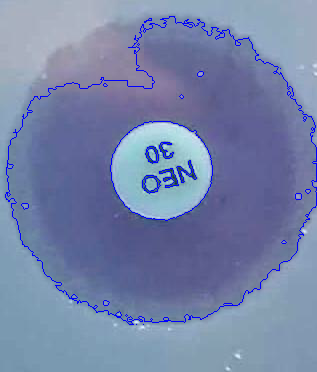

In [23]:
# You can choose either to use contours_inv or contours_binary
cv2.drawContours(open_cv_image, contours_inv, -1, (255, 0, 0), 0)
#cv2.drawContours(open_cv_image, contours_binary, -1, (255, 0, 0), 0)
cv2_imshow(open_cv_image)

In [34]:
# There are many contours in the above image.  I choose the largest and the second largest.
# Then draw a bounding box on each one of them.

max_list = []
for i in range(len(contours_inv)):
    cont_list = contours_inv[i].size
    max_list.append(cont_list)

max_list_sorted = sorted(max_list, reverse=True)
max_1 = max_list_sorted[0]
max_2 = max_list_sorted[1]
largest_1 = [i for i, j in enumerate(max_list) if j == max_1]
largest_2 = [i for i, j in enumerate(max_list) if j == max_2]
print(f'Largest contour in index: {largest_1} of max_list')
print(f'Second largest contour in index: {largest_2} of max_list.')

Largest contour in index: [42] of max_list
Second largest contour in index: [26] of max_list.


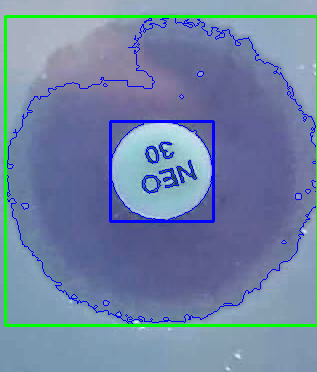

In [62]:
# Draw a rectangle outside of the zone of inhibtion contour line
zone_largest = contours_inv[largest_1[0]]
x_1, y_1, w_1, h_1 = cv2.boundingRect(zone_largest)

# Draw the rectangle in green
cv2_rect_image = cv2.rectangle(open_cv_image, (x_1, y_1), (x_1 + w_1, y_1 + h_1), (0,255,0), 2)
cv2.imwrite('/content/zone_inhibition.jpg', cv2_rect_image)
cv2_imshow(cv2_rect_image)


In [47]:
print(f'Green box(zone of inhibtion) width {w_1} pixels')

Green box(zone of inhibtion) width 312 pixels


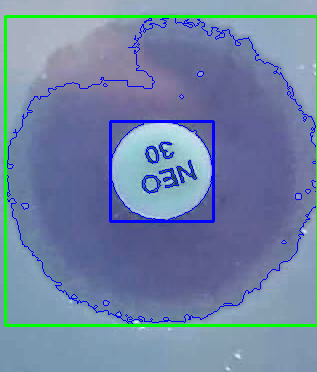

In [45]:
# Draw a rectangle outside of the disk contour line.
disk_largest = contours_inv[largest_2[0]]
x_2, y_2, w_2, h_2 = cv2.boundingRect(disk_largest)

# Draw the rectangle in blue
cv2.rectangle(open_cv_image,(x_2, y_2), (x_2 + w_2, y_2 + h_2), (255, 0, 0), 2)
cv2_imshow(open_cv_image)

In [48]:
print(f'Blue box(disk) width {w_2} pixels')

Blue box(disk) width 103 pixels


In [50]:
# The size of disk in general is 0.7cm.
# x is unknown value
disk_cm = 0.7
zone_width = x/w_1
disk_width = disk_cm/w_2
x = (w_1 * disk_cm)/w_2
print(f'Size of zone of inhibition in cm is {x}')

Size of zone of inhibition in cm is 2.120388349514563


### Reference:
* https://github.com/facebookresearch/detectron2
* https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/
* https://docs.opencv.org/3.4/d4/d70/tutorial_hough_circle.html
* https://stackoverflow.com/questions/44588279/find-and-draw-the-largest-contour-in-opencv-on-a-specific-color-python
* https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
* https://stackoverflow.com/questions/54065119/intersect-image-with-mask-in-skimage
* https://hub.packtpub.com/opencv-detecting-edges-lines-shapes/
* https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
* https://stackoverflow.com/questions/56781635/find-extreme-outer-points-in-image-with-python-opencv
* https://stackoverflow.com/questions/36911877/cropping-circle-from-image-using-opencv-python
* 